In [2]:
from PIL import Image
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import math
import random
import argparse
import logging
import json
import cv2
import datetime

#import shapely.wkt
#import shapely
#from shapely.geometry import Polygon
from collections import defaultdict
from sklearn.model_selection import train_test_split
logging.basicConfig(level=logging.INFO)

# Configurations
NUM_WORKERS = 4
NUM_CLASSES = 4
BATCH_SIZE = 64
NUM_EPOCHS = 120
LEARNING_RATE = 0.0001
RANDOM_SEED = 123
LOG_STEP = 150

damage_intensity_encoding = defaultdict(lambda: 0)
damage_intensity_encoding['destroyed'] = 3
damage_intensity_encoding['major-damage'] = 2
damage_intensity_encoding['minor-damage'] = 1
damage_intensity_encoding['no-damage'] = 0

In [4]:
def process_img(img_array, polygon_pts, scale_pct):
    """Process Raw Data into

            Args:
                img_array (numpy array): numpy representation of image.
                polygon_pts (array): corners of the building polygon.

            Returns:
                numpy array: .

    """

    height, width, _ = img_array.shape

    xcoords = polygon_pts[:, 0]
    ycoords = polygon_pts[:, 1]
    xmin, xmax = np.min(xcoords), np.max(xcoords)
    ymin, ymax = np.min(ycoords), np.max(ycoords)

    xdiff = xmax - xmin
    ydiff = ymax - ymin

    #Extend image by scale percentage
    xmin = max(int(xmin - (xdiff * scale_pct)), 0)
    xmax = min(int(xmax + (xdiff * scale_pct)), width)
    ymin = max(int(ymin - (ydiff * scale_pct)), 0)
    ymax = min(int(ymax + (ydiff * scale_pct)), height)

    return img_array[ymin:ymax, xmin:xmax, :]

In [ ]:
process_img()

# --> Youtube Video Codes

https://www.youtube.com/watch?v=-XeKG_T6tdc

In [3]:
# install the latest version of tensorflow
%pip install tensorflow==2.13.0

#check later if the segmentation model will give an error 
# due to the latest version

  Obtaining dependency information for tensorflow==2.13.0 from https://files.pythonhosted.org/packages/d6/69/d461fa09235326e08b7ca463d5491426fdd4908ef6d3f9ed51d0777dc071/tensorflow-2.13.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for tensorflow-macos==2.13.0 from https://files.pythonhosted.org/packages/f1/cc/6c262ae6f3a23b118b1104fa5f6126067744ffa9226faade202b0a20bdd3/tensorflow_macos-2.13.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached absl_py-1.4.0-py3-none-any.whl (126 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)


In [4]:
#import tensorflow
import tensorflow as tf

In [5]:
# check tensorflow version and set verbosity
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(v=tf.compat.v1.logging.INFO)

2.13.0


In [6]:
# to train patches of data of 1024 x 1024, install patchify

%pip install patchify

Note: you may need to restart the kernel to use updated packages.


In [7]:
import keras
keras.__version__

'2.13.1'

In [8]:
#to define the pre trained model as the decoder part of the model
%pip install segmentation-models==1.0.1 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00
  Obtaining dependency information for scikit-image from https://files.pythonhosted.org/packages/20/54/06f821fd78c24f7047629dc4c8ed948101fc91fdf660ee3263d870220ae8/scikit_image-0.21.0-cp311-cp311-macosx_12_0_arm64.whl.metadata
  Using cached networkx-3.1-py3-none-any.whl (2.1 MB)
  Obtaining dependency information for imageio>=2.27 from https://files.pythonhosted.org/packages/c7/b0/7b6c35b8636ed773325cdb6f5ac3cd36afba63d99e20ed59c521cf5018b4/imageio-2.31.1-py3-none-any.whl.metadata
  Using cached imageio-2.31.1-py3-none-any.whl.metadata (4.7 kB)
  Obtaining dependency information for tifffile>=2022.8.12 from https://files.pythonhosted.org/packages/2d/e5/cc8a8ca43685006bb3ca56fab60707f3f74700844b18634db0b1e8b4b93f/tifffile-2023.7.18-py3-none-any.whl.metadata
  Using cached tifffile-2023.7.18-py3-none-any.whl.metadata (32 kB)
  Using cached PyWavelets-1.4.1-cp311-cp311-macosx_11_0_arm64.whl (4.3 MB)
  Obtaini

In [9]:
import numpy as np
from matplotlib import pyplot as plt
from patchify import patchify
import tifffile as tiff

## Load the data and convert to np array

In [10]:
%pip install Pillow


[notice] A new release of pip is available: 23.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
#run the following command and then comment it out

# pip install --upgrade pip

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/50/c2/e06851e8cc28dcad7c155f4753da8833ac06a5c704c109313b8d5a62968a/pip-23.2.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.4 MB/s eta 0:00:0031m10.7 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 23.2
    Uninstalling pip-23.2:
      Successfully uninstalled pip-23.2
Note: you may need to restart the kernel to use updated packages.


In [12]:
# load necessary packages
from PIL import Image
import os
import numpy as np

In [28]:
def load_images_and_masks(image_dir, mask_dir):

    """Loads all the png images and converts them to a numpy array

    Returns:
        images: np array
        masks: np array
    """    
    image_filenames = os.listdir(image_dir)
    mask_filenames = os.listdir(mask_dir)
    images = []
    masks = []

    for image_filename in image_filenames:
        image_path = os.path.join(image_dir, image_filename)
        mask_filename = image_filename.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_filename)

        if os.path.exists(mask_path):
            image = Image.open(image_path)
            mask = Image.open(mask_path)

            # Convert images and masks to NumPy arrays
            image_np = np.array(image)
            mask_np = np.array(mask)

            images.append(image_np)
            masks.append(mask_np)

    return images, masks



In [29]:
# Replace 'image_dir' and 'mask_dir' with the paths to your image and mask directories
image_dir = '/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_minisubset_reorganized/all_images/'
mask_dir = '/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_minisubset_reorganized/all_masks/'

images, masks = load_images_and_masks(image_dir, mask_dir)

In [30]:
#convert lists to np arrays
images=np.array(images)
images.shape
print(images)

[]


In [16]:
# load one image
example_image = Image.open('/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_minisubset_reorganized/all_images/mexico-earthquake_00000005_post_disaster.png')
example_mask = Image.open('/Users/sevincjakab/neuefische_bootcamp/20230717-NewRepo-Capstone-Building_Damage/Capstone_Building_Damage/data/xBD_minisubset_reorganized/all_masks/mexico-earthquake_00000005_pre_disaster.png')


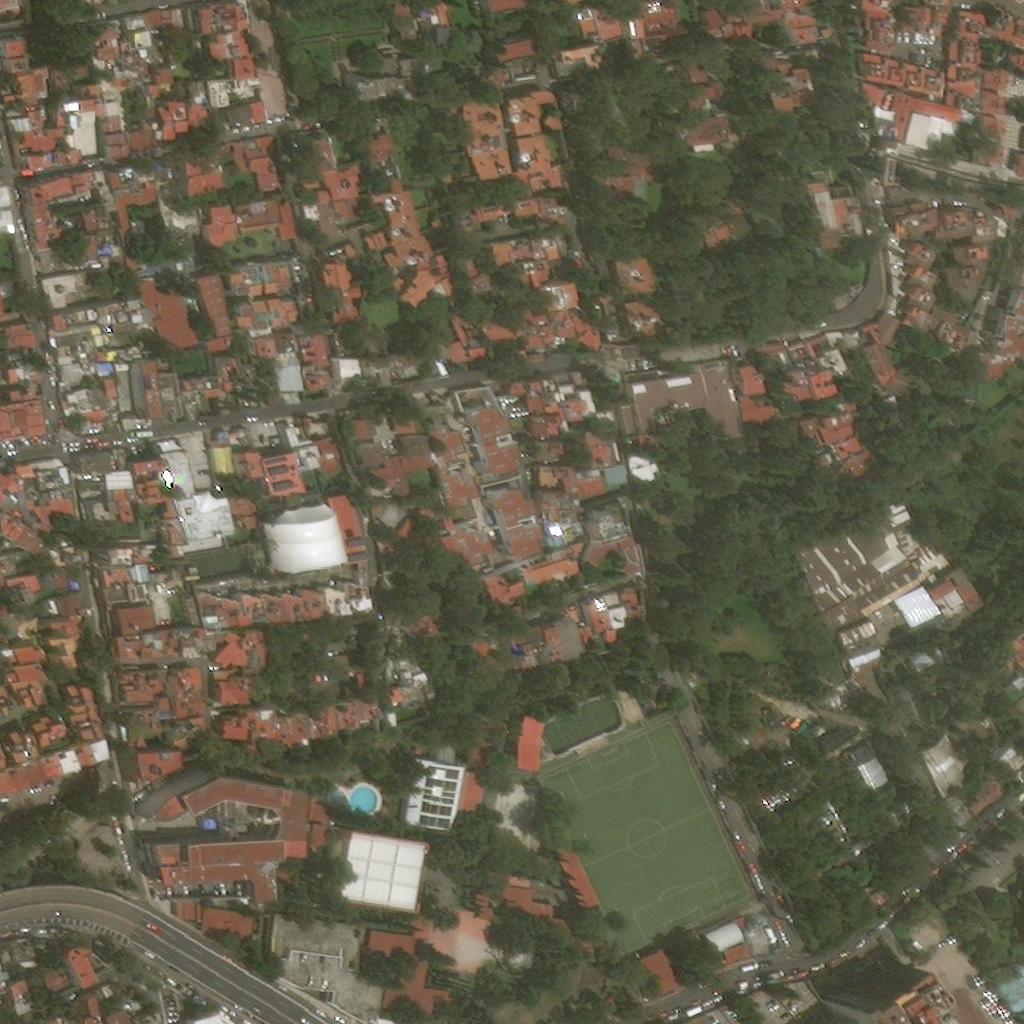

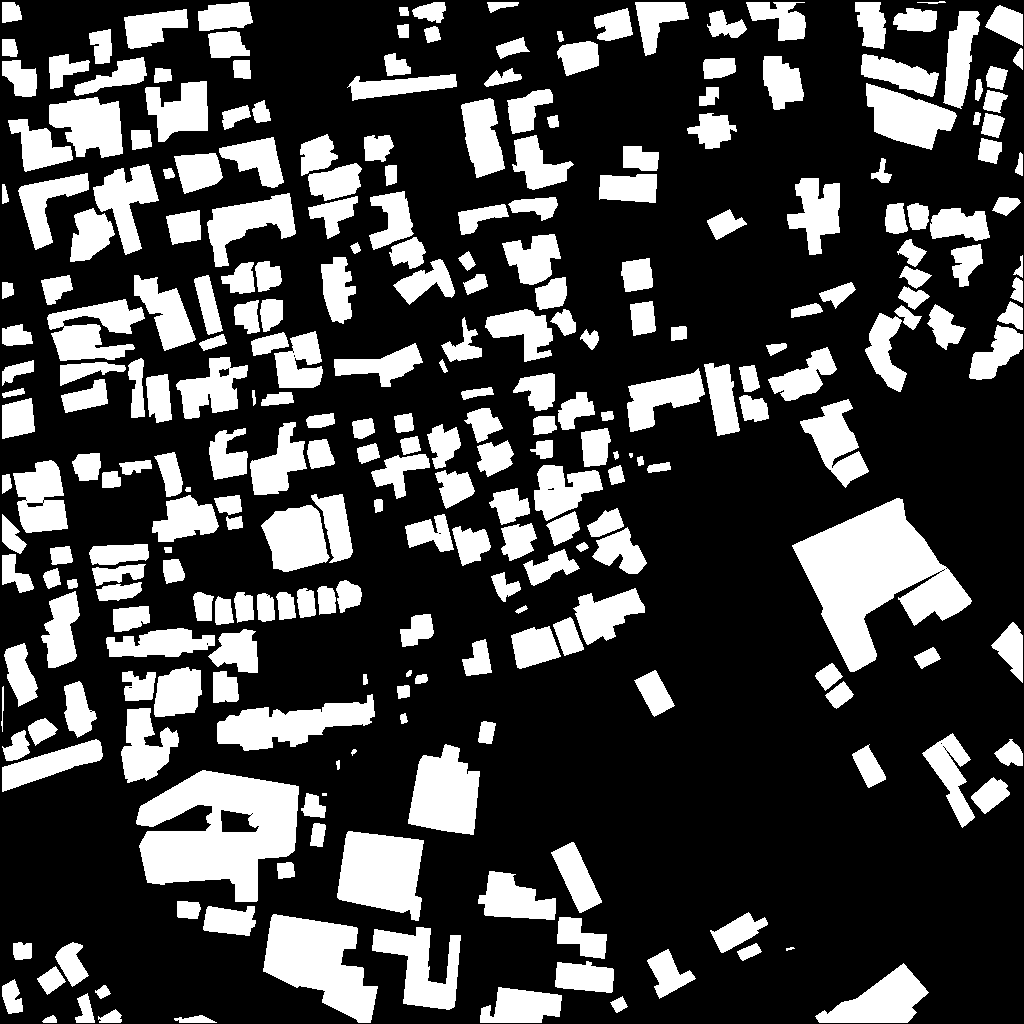

In [24]:
from IPython.display import display
display(example_image)
display(example_mask)

In [18]:
print(example_image)
print(example_mask)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x17D975E90>
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=1024x1024 at 0x28A561490>


skip this line for now

In [ ]:
# get image and mask pixels in an array
# we make 256 x 256 patches  (splitting one image to 16 patches)
# all_img_patches = []
# for img in range(large_image_stack.shape[0]):
#     #print(img)     #just stop here to see all file names printed
     
#     large_image = large_image_stack[img]
    
#     patches_img = patchify(large_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

#     for i in range(patches_img.shape[0]):
#         for j in range(patches_img.shape[1]):
            
#             single_patch_img = patches_img[i,j,:,:]
#             single_patch_img = (single_patch_img.astype('float32')) / 255.
            
#             all_img_patches.append(single_patch_img)

# images = np.array(all_img_patches)
# images = np.expand_dims(images, -1)

# all_mask_patches = []
# for img in range(large_mask_stack.shape[0]):
#     #print(img)     #just stop here to see all file names printed
     
#     large_mask = large_mask_stack[img]
    
#     patches_mask = patchify(large_mask, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

#     for i in range(patches_mask.shape[0]):
#         for j in range(patches_mask.shape[1]):
            
#             single_patch_mask = patches_mask[i,j,:,:]
#             # at this step check what the pixel values for masks are
#             #single_patch_mask = single_patch_mask / 255.
            
#             all_mask_patches.append(single_patch_mask)


# masks = np.array(all_mask_patches)
# masks = np.expand_dims(masks, -1)

In [ ]:
# check the dimensions of the images and masks array
print(images.shape)
print(masks.shape)
print("Pixel values in the mask are: ", np.unique(masks))

In [ ]:
# SegFormer model --check how to call the model and preprocess the data accordinly!

from transformers import SegformerFeatureExtractor, SegformerForImageClassification
from PIL import Image
import requests

#url = "http://images.cocodataset.org/val2017/000000039769.jpg"
#image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/mit-b0")
model = SegformerForImageClassification.from_pretrained("nvidia/mit-b0")

inputs = feature_extractor(images=images, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])


# -->Helper Code from Previous Noteboooks Below

## 1- Preprocessing

Part1 and part2
- uses shell commands to prepare the data in a way that it can be loaded into tensorflow, 
- split our data into a train and validation set (can be skipped if data are in separate folders)
- loads the data
- defines some functions that will allow us to directly import our pictures and the corresponding class labels 
- defines functions for data augmentation (Note: Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It is done to prevent overfitting).It includes making minor changes to the dataset or using deep learning to generate new data points.)
- defines a function to automatically add other functions to a python file.

Below is how the codes are adjusted from Image_Modeling Notebook1 and Notebook2:

- `flowers_train.csv` replaced with `buildings_train.csv`
- `flowers_eval.csv` replaced with `buildings_validation.csv`
- `flowers_test.csv` replaced with `buildings_test.csv`
- `Image_Modeling.py` replaced with `Building_Damage-Python.py`




--!Check what the following cell does

In [ ]:
# Remove any file that gets constructed by the notebook.
!rm -f Building_Damage-Python.py buildings_train.csv buildings_validation.csv buildings_test.csv

In [ ]:
# Below code helps us to register the consecutive cells automatically into a
# python script whenever we put %%write_and_run Building_Damage-Python.py at the 
# beginning of that cell
from IPython.core.magic import register_cell_magic

@register_cell_magic
def write_and_run(line, cell):
    """write python code into file and execute it as well"""

    argz = line.split()
    file = argz[-1]
    mode = 'w'
    if len(argz) == 2 and argz[0] == '-a':
        mode = 'a'
        print("Appended to file ", file)
    else:
        print('Written to file:', file)
    with open(file, mode) as f:
        f.write(cell.format(**globals()))        
    get_ipython().run_cell(cell)

In [2]:
# load libraries
import pathlib
import IPython.display as display
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

#load more libraries here if necessary

ModuleNotFoundError: No module named 'tensorflow'

In [1]:
# check tensorflow version and set verbosity
print(tf.__version__)
tf.compat.v1.logging.set_verbosity(v=tf.compat.v1.logging.INFO)

NameError: name 'tf' is not defined

In [ ]:
#loading the data ?

# Note: in Nt1 of Image_Modeling repo, the data was downloaded. There is 
# code for that in that nt

!Check what the cell below does

In [ ]:
# Adjust the code below for this notebook

# Get paths as POSIX paths
home_path = str(pathlib.Path.home())
data_dir = home_path + '/.keras/datasets/flower_photos' #adjust here
data_dir = pathlib.Path(data_dir)

# count available images
image_count = len(list(data_dir.glob('*/*.tiff')))
print("We have", image_count, "images.")

# Get classes
CLASS_NAMES = np.array(
    [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"] # adjust here
)
print("We have the following classes in the data: ", CLASS_NAMES)

In [ ]:
# count number of images per class
for cls in CLASS_NAMES:
    image_count = len(list(data_dir.glob(cls+'/*.tiff')))
    print("We have", image_count, cls, "images.")

In [ ]:
# Get all images from one label. Adjust the code below.
# We can write a for loop to check 1 image per class label
label1 = list(data_dir.glob('label1/*')) # replace label1

# display 3 images
for image in label1[:3]: # replace label1
    display.display(Image.open(str(image)))

## 2- Data Preparation Using Shell Commands

### 2.1- Reaching at the labels

--Adjust the text and the code below

`buildings_train_generic.csv` contains the paths to the images and their respective classes. Let's look at the first five entries. First we use the [head](https://linuxhint.com/bash_head_tail_command/) command to generate the first five lines of the `buildings_train_generic.csv`. Then we redirect the output of the [head](https://linuxhint.com/bash_head_tail_command/) command to the `/tmp/input.csv` via the ['>'](https://www.cs.ait.ac.th/~on/O/oreilly/unix/upt/ch13_01.htm#UPT-ART-1023) operator. We now print the content of this file with the [cat](https://www.interserver.net/tips/kb/linux-cat-command-usage-examples/?__cf_chl_f_tk=sbsfrwcq2e.iPk93oGmvT0LSXdGVW7BuzsZsRhl85GI-1642513145-0-gaNycGzNCOU) command. We separate the cat command by using pipe operator '|'.

In [ ]:
# Let us take a look into the training set - inspect the first 5 lines with 'head'
!head -5 labels.csv > /tmp/input.csv | cat

# This is the same thing as:
# !head -5 labels.csv > /tmp/input.csv 
# !cat /tmp/input.csv

### 2.2- Correcting the name of the labels for tensor flow

`If the result of the above code contains '~', continue here:`

Unfortunately the Tensorflow Dataset API cannot handle '~'. So we write new files containing the user path instead of '~', named buildings_train.csv and buildings_test.csv

- first we generate standard output with the content of labels_train_generic.csv with the cat command.
- the [pipe operator](https://www.cs.ait.ac.th/~on/O/oreilly/unix/upt/ch13_01.htm#UPT-ART-1023) '|' uses the output of whats left of it as the input for whats right of it.
- so we use the output of cat as input of the [sed](https://www.geeksforgeeks.org/sed-command-in-linux-unix-with-examples/?ref=lbp) command. Note: here the delimiter is '+'
- the 's' in `s+~+{home_path}+g` specifies the substitution operation and 'g' stands for globally so all occurrences will be replaced.
- finally sed `s+~+{home_path}+g` replaces all '~' with the home_path variable and the output is written to a new file via '>'
- `home_path` is the variable we defined above.

In [ ]:
# TensorFlow Dataset API cannot work with the '~' character,
# so we replace it with the specific user path using 'sed'
# and save it in another file using '>' operator
!cat buildings_train_generic.csv | sed 's+~+{home_path}+g' > buildings_train.csv # adjust
!cat buildings_test_generic.csv | sed 's+~+{home_path}+g' > buildings_test.csv # adjust


In [ ]:
#check first 5 elements in the train
!head -5 buildings_train.csv

In [ ]:
#check first 5 elements in the test
!head -5 buildings_test.csv

### 2.3- Train-Validation (Holdout) Split

`if the data is already split, you can skip this step`

Now the paths in `buildings_train.csv` and `buildings_test.csv` are in the path format needed for Tensorflow.

In order to be able to see if our model is overfitting we need to split our train set again into a train set and an evaluation set. To make results comparable we want to randomly split with a seed specified by the file random.seed. 

- first we use the `sort -R` command to shuffle the lines in flowers_train.csv. `--random-source=random.seed` sets the random seed.
- then we use this output as input for the [split -l](https://www.geeksforgeeks.org/split-command-in-linux-with-examples/) command via pipe ('|').
- `split -l` then takes the pseudo randomized data and splits it into two files after a specified number of lines. 
- the [wc -l](https://www.geeksforgeeks.org/wc-command-linux-examples/) counts the number of lines in a file.
- So finally we get a train file with `x number` and a evaluation file with `y number` lines.

>__Exercise__: use the `wc -l` command to check the length of the two files in your terminal

Note that due to the `%%bash` in the beginning of the cell we can omit the usual '!' in front of the shell command. 

In [ ]:
#adjust below code (figure out what 'flowers' is for)

%%bash
# Let us also create an evaluation set from the train set.
# We want to have a fixed seed.
# NOTE: 'sort -R' is used to shuffle the data. If there are
# duplicates it sorts them next to each others, which we 
# want to have, since we want to avoid evaluation leakage.

echo "files before splitting:"
ls flowers*  #Is flowers the name of the labels file or images file?
sort -R buildings_train.csv --random-source=random.seed | split -l $(( $(wc -l <buildings_train.csv) - 370)) - buildings_train

echo # print empty line
echo "files after splitting:"
ls flowers* #?
# results of split are written into two files automatically: a and b refer to train and test
mv buildings_trainaa buildings_train.csv 
mv buildings_trainab buildings_validation.csv
echo; echo "files after renaming:"
ls flowers* #?

In [ ]:
%%bash
# count lines in all csv files
wc -l *.csv

### 2.4- Extract the Labels from Train Set

Next we want to extract the labels from the `buildings_train.csv`. 

- [awk](https://www.geeksforgeeks.org/awk-command-unixlinux-examples/) lets you, amongst other things, select fields separated by white spaces in a file.
- [uniq](https://linuxhint.com/bash_uniq_command/) removes adjacent duplicate lines from a file.


In [ ]:
# Extract the labels from the train data 
#########################################
# cat: read file content 
# sed: replace comma by space 
# awk: extract column 2 separated by space 
# sort: sort labels
# uniq: extract unique labels 
# > write data to file
!cat buildings_train.csv | sed 's/,/ /g' | awk '{print $2}' | sort | uniq > /tmp/labels.txt #adjust
# cat: display file content 
!cat /tmp/labels.txt

### 2.5- Define Functions to Process the Data (Decoding and Loading the Data)

We set some parameters for the model and call the register cell magic `write_and_run` again this time with the `-a` flag. This makes sure that the content of the cell is appended to `.py` and existing lines are not overwritten.

`tf.data` builds a performance model of the input pipeline and runs an optimization algorithm to find a good allocation of its CPU budget across all parameters specified as `AUTOTUNE`. While the input pipeline is running, `tf.data` tracks the time spent in each operation, so that these times can be fed into the optimization algorithm.

The [OptimizationOptions](https://www.tensorflow.org/api_docs/python/tf/data/experimental/OptimizationOptions) object gives some control over how autotune will behave.

In [ ]:
%%write_and_run -a Building_Damage-Python.py

# adjust the code below 

# We set some parameters for the model
# image characteristics
HEIGHT = 1024 #image height
WIDTH = 1024 #image width
CHANNELS = 3 #image RGB channels

# label characteristics
CLASS_NAMES = ['label1', 'label2', 'label3', 'label4', 'label5'] # put all the label names
NCLASSES = len(CLASS_NAMES)

# algorithmic parameters
BATCH_SIZE = 10 #adjust
SHUFFLE_BUFFER = 10 * BATCH_SIZE #adjust
AUTOTUNE = tf.data.experimental.AUTOTUNE # what does this code do?

VALIDATION_SIZE =  # enter a number here depending on how many samples are in train set
VALIDATION_STEPS = VALIDATION_SIZE // BATCH_SIZE

In [ ]:
%%write_and_run -a Building_Damage-Python.py

# Define the function that decodes the images--adjusted for tiff images
def decode_image(image, reshape_dim):
    """decode image based on image loaded image and its size dimension

    Args:
        image (_type_): <class 'tensorflow.python.framework.ops.EagerTensor'> e.g. from tf.io.read_file(<filename>)
        reshape_dim (_type_): list with height and width

    Returns:
        tensor representation of the image
    """
     
    # we convert tiff format to a numpy array we can compute with.
    image = tf.image.decode_tiff(image, channels=CHANNELS)
    # 'decode_jpeg' returns a tensor of type uint8. I replaced it with
    # decode_tiff. We need  32bit floats for the model. Actually we want 
    # them to be in the [0,1] interval. I am not sure if we need to change
    # them to float for tiff (?)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Now we can resize to the desired size.
    image = tf.image.resize(image, reshape_dim)
    
    return image

In [ ]:
# test the decoding function
img = tf.io.read_file(home_path + '/xxx.tiff')  #adjust
print(type(img), "\n")

# TODO: take the function above and decode the image
decode_image(img,[HEIGHT, WIDTH])

We need a function that takes a row containing paths and classes and returns the actual images and a label vector which is true at the position of the class of the image, defined by CLASS_NAMES above and false otherwise (one-hot-encoding). The decode_dataset function does this for us. It will be used later and written to the end of `image_modeling.py`

In [ ]:
%%write_and_run -a Building_Damage-Python.py

# check again what this cell does

# The train set actually gives only the paths to the training images.
# We want to create a dataset of training images, so we need a 
# function that can handle this for us.
def decode_dataset(data_row):
    # extract image path and class label for a single row from csv
    record_defaults = ['path', 'class']
    # read row of csv
    filename, label_string = tf.io.decode_csv(data_row, record_defaults)
    # read image into class 'tensorflow.python.framework.ops.EagerTensor'
    image_bytes = tf.io.read_file(filename=filename)
    # read label - looks like: Tensor("Equal:0", shape=(5,), dtype=bool)
    label = tf.math.equal(label_string, CLASS_NAMES)
    return image_bytes, label

In the next cell you can see how a Tensorflow data set will look like. Tensorflow data sets will be iterable objects and we can use `.decode_csv` to unpack the content into a path and a class label.

In [ ]:
# check again what this cell does

# read training data for iteration and decode the csv to get filename and label
dataset = tf.data.TextLineDataset('flowers_train.csv')
it = iter(dataset)

# unpack tensorflow object content into file path and class label string
record_defaults = ['path', 'class'] # defines dtype
# output dtype of decode_csv will be two strings
# could have written ['chicken','egg'] with same outcome. But not e.g. [1,'class'].
filename, label_string = tf.io.decode_csv(next(it), record_defaults)
filename, label_string

### 2.6- Data Augmentation

In [ ]:
%%write_and_run -a Building_Damage-Python.py

# Next we construct a function for pre-processing the images.
def read_and_preprocess(image_bytes, label, augment_randomly=False):
    """randomly transform image, if augment_randomly == True"""
    # transform image randomly
    if augment_randomly:
        # increase image size 
        image = decode_image(image_bytes, [HEIGHT + 8, WIDTH + 8])
        # TODO: Augment the image.
        # randomly crop image 
        image = tf.image.random_crop(image, size=[HEIGHT, WIDTH, 3])
    # use original image 
    else:
        image = decode_image(image_bytes, [HEIGHT, WIDTH])
    return image, label

def read_and_preprocess_with_augmentation(image_bytes, label): 
    """read images and augment randomly"""
    return read_and_preprocess(image_bytes, label, augment_randomly=True)

### 2.7- Loading the Data with the Labels

Finally we can define a function that loads and preprocesses our data by combining the functions defined above. 
- the `load_dataset` function applies (`map`) the `decode_dataset` to every element in the dataset.
- for training:
    - the data should use your augmentation implementation (`#TODO`).
    - then the data will be [shuffled](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) to avoid the risk to create batches that are not representative of the overall dataset. Second answer in [this](https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning-tasks) thread for more details.
    - we can go through the dataset infinite times.
- for evaluation:
    - the data is neither shuffled or augmented, just read and preprocessed.
    - we only need to go through the whole dataset once, hence `repeat(count=1)`. Will just stop after end is reached.
- finally batches of size `batch_size` will be produced with each iteration step.
- with `prefetch(buffer_size=AUTOTUNE)` an optimized number batches are prepared while prior ones are trained on.

In [ ]:
%%write_and_run -a Building_Damage-Python.py

# Now we can create the dataset.
def load_dataset(file_of_filenames, batch_size, training=True):
    # We create a TensorFlow Dataset from the list of files.
    # This dataset does not load the data into memory, but instead
    # pulls batches one after another.
    dataset = tf.data.TextLineDataset(filenames=file_of_filenames).\
        map(decode_dataset)
    
    # important: augmentation only used during training!
    if training:
        # TODO: Use augmentation here.
        dataset = dataset.map(read_and_preprocess_with_augmentation).\
            shuffle(SHUFFLE_BUFFER).\
            repeat(count=None) # Infinite iterations

        # # previous function that got replaced by another with augmentation
        # dataset = dataset.map(read_and_preprocess).\
        #     shuffle(SHUFFLE_BUFFER).\
        #     repeat(count=None) # Infinite iterations
    
    else: 
        # Evaluation or testing
        dataset = dataset.map(read_and_preprocess).\
            repeat(count=1) # One iteration
            
    # The dataset will produce batches of BATCH_SIZE and will automatically
    # prepare an optimized number of batches while the prior one is trained on.
    return dataset.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Use load_dataset function 

# check if data loading works as intended.
train_path = 'flowers_train.csv'
train_data = load_dataset(train_path, 1)
# Create an iterator that runs over the training dataset.
it = iter(train_data)

In [ ]:
# Iterate and see the pictures and labels
# use 'next' to go to next image (as 'it' is an iterator that runs over the training dataset)
img_batch, labels = next(it)
# show random image
image = img_batch[0]
plt.imshow(image)
print(labels[0])

In [ ]:
# show another image
img_batch, labels = next(it) 
image = img_batch[0]
plt.imshow(image)
print(labels[0])

# 3- Check Parameters from Python File before Training

In [ ]:
# Import required packages 
# import tensorflow as tf --> already imported in part2
import tensorflow_hub as hub
import datetime

# import image_modeling.py file created with NB1
import Building_Damage-Python

# Load the TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
# run this in case you need to clear any logs from previous runs
# !rm -rf ./logs/

In [ ]:
# Import variables from Building_Damage-Python.py file
HEIGHT = image_modeling.HEIGHT
WIDTH = image_modeling.WIDTH
NCLASSES = image_modeling.NCLASSES
CLASS_NAMES = image_modeling.CLASS_NAMES
BATCH_SIZE = image_modeling.BATCH_SIZE
TRAINING_SIZE = !wc -l < buildings_train.csv
TRAINING_STEPS = int(TRAINING_SIZE[0]) // BATCH_SIZE

# set paths to data sets
TRAIN_PATH = 'buildings_train.csv'
EVAL_PATH = 'buildings_validation.csv'
TEST_PATH = 'buildings_test.csv'

In [ ]:
# double check if the variables now contain the correct values.
print(HEIGHT)
print(CLASS_NAMES)
print(NCLASSES)

# 4- Load Pretrained Models (Transfer Learning)

## refer to Nt2 of Image_Modeling

# 5- Train the Model/s

# 6- Metrics for Model Performance